<a href="https://colab.research.google.com/github/andrejadikic/FileLocalImpl/blob/main/Domaci1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Zadatak 1

In [ ]:
import threading
import random
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML

values = [0,1]
n = 5
#state je trenutno stanje matrice
#state = np.random.choice(values, n*n).reshape(n,n)
state = np.zeros((n, n)).astype(np.int8)
state[1][2]=1;
state[2][2]=1;
state[3][2]=1;
steps = [state]


#steps je matrica stanja koja pamti promenu stanja od iteracije do iteracije
#steps = [(np.random.rand(n**2).reshape(n, n) > 0.5).astype(np.int8)for i in range(n)]

#readcounters je brojac suseda koji su procitali trenutnu vrednost kad dodje do 8 onda se menja vrednost celije
readcounters = np.zeros((n, n)).astype(np.int8)
#cell_lock_counter za state da se menja 
cell_lock_counter = np.array([threading.Lock() for i in range(n*n)]).reshape(n,n)
# matrica key za readcounter
read_key = np.array([threading.Lock() for i in range(n*n)]).reshape(n,n)
# iter_lock je lock za sledecu iteraciju
iter_lock = threading.Lock()
# iter_counter broji koliko celija je uslo u cekaonicu
iter_counter = 0
# finish_counter koliko je izaslo iz 
finish_counter = n*n
#state = [(np.random.rand(n*n).reshape(n,n)>0.5).astype(np.int8)]

cond = 1

cond_key = threading.Lock()
wake_key = threading.Lock()

def wakeUp(x,y):
    global n
    global cell_lock_counter
    global readcounters
    global cell_lock_counter

    if( ((x==0 or x==n) and (y>0 and y<n)) or ((y==0 or y==n) and (x>0 and x<n)) ) and readcounters[x][y]==5:
      read_key[x][y].acquire
      readcounters[x][y]=0
      read_key[x][y].release
      cell_lock_counter[x][y].release
      return 1
    elif (x==0 or x==n) and (y==0 or y==n) and readcounters[x][y]==3:
      read_key[x][y].acquire
      readcounters[x][y]=0
      read_key[x][y].release
      cell_lock_counter[x][y].release
      return 1
    elif (x>0 and x<n) and (y<n and y>0) and readcounters[x][y]==8:
      read_key[x][y].acquire
      readcounters[x][y]=0
      read_key[x][y].release
      cell_lock_counter[x][y].release
    return 0

def getValue(x,y):
    global n
    global state
    global read_key
    global readcounters

    if (x>=0 and x<n and y>=0 and y<n):
      read_key[x][y].acquire
      readcounters[x][y] += 1
      read_key[x][y].release
      wakeUp(x,y)
      return state[x][y]
    return 0;


def count_alive_cells(curr_x, curr_y):
    alive_cells = 0
    cordinates = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]

    for i,j in cordinates:
      alive_cells += getValue(curr_x+i,curr_y+j)

    wakeUp(curr_x,curr_y)
    return alive_cells

def isAlive(curr_val,alive_neigbors):
    if(alive_neigbors<2 or alive_neigbors>3):
      return 0
    elif((alive_neigbors==2 or alive_neigbors==3) and curr_val==1) or (curr_val==0 and alive_neigbors==3):
      return 1
    return curr_val

def copyState(s):
  states = []
  states = s.copy()
  return states

def playGame(x,y):
    global n
    global steps
    global state
    global finish_counter # koliko su izasli iz cekaonice
    global iter_lock
    global iter_counter # koliko su usli u cekaonicu
    global cond # uslov
    global cell_lock_counter #lock[x][y] za state da se menja state[x][y]
    global cond_key
    global wake_key

    count = count_alive_cells(x,y)
    newState = isAlive(state[x][y],count)
    #print(newState,x,y,sep=" ")

    if(iter_counter==0 and finish_counter == n*n and cond==1):  # prva nit ulazi u cekaonicu
      steps.append(copyState(state))
      cond=0
      cond_key.acquire
      iter_lock.acquire
      iter_counter = 1
      iter_lock.release
      wake_key.acquire
      finish_counter=0
      wake_key.release
    elif(iter_counter==n*n): # poslednja nit usla u cekaonicu
      iter_lock.acquire
      iter_counter = 0
      iter_lock.release
      cond=1
      cond_key.release
    else:
      iter_lock.acquire
      iter_counter+=1
      iter_lock.release
    #else: # ni jedna ni druga
     # cond_key.acquire
      #if(cond):
       # cell_lock_counter[x][y].acquire
        #state[x][y] = newState;
       # finish_counter+=1
      #  cond_key.release
    
    cond_key.acquire
    cell_lock_counter[x][y].acquire
    state[x][y] = newState;
    wake_key.acquire
    finish_counter+=1
    wake_key.release
    cond_key.release

def animate(steps):
  ''' Prima niz matrica (svaka matrica je stanje u jednom koraku simulacije) 
  prikazuje razvoj sistema'''
  
  def init():
    im.set_data(steps[0])
    return [im]
  
  
  def animate(i):
    im.set_data(steps[i])
    return [im]

  im = plt.matshow(steps[0], interpolation='None', animated=True);
  
  anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                  frames=len(steps), interval=500, blit=True, repeat=False);
  return anim


threads=[]

for k in range(10):
  for i in range(n):
    for j in range(n):
      t = threading.Thread(target=playGame, args=(i,j))
      t.start()
      threads.append(t)

for t in threads:
  t.join()

anim = animate(steps)
HTML(anim.to_html5_video())

Zadatak2

In [ ]:
import threading
import random
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML
import time

values = [0,1]
n = 5
#state je trenutno stanje matrice
#state = np.random.choice(values, n*n).reshape(n,n)
state = np.zeros((n, n)).astype(np.int8)
state[1][2]=1;
state[2][2]=1;
state[3][2]=1;
steps = [state]

#readcounters je brojac suseda koji su procitali trenutnu vrednost kad dodje do 8 onda se menja vrednost celije
readcounters = np.zeros((n, n)).astype(np.int8)
# matrica key za menjanje
read_key = np.array([threading.Lock() for i in range(n*n)]).reshape(n,n)

count = 0
condition = threading.Condition()
key = threading.Lock()

def wakeUp(x,y):
    global n
    if( ((x==0 or x==n-1) and (y>0 and y<n-1)) or ((y==0 or y==n-1) and (x>0 and x<n-1)) ) and readcounters[x][y]==5:
      return 1
    elif (x==0 or x==n-1) and (y==0 or y==n-1) and readcounters[x][y]==3:
      return 1
    elif (x>0 and x<n-1) and (y<n-1 and y>0) and readcounters[x][y]==8:
      return 1
    return 0


def isAlive(curr_val,alive_neigbors):
    if(alive_neigbors<2 or alive_neigbors>3):
      return 0
    elif((alive_neigbors==2 or alive_neigbors==3) and curr_val==1) or (curr_val==0 and alive_neigbors==3):
      return 1
    return curr_val

def copyState(s):
  states = []
  states = s.copy()
  return states

def playGame(x,y, iteration=10):
    global n
    global steps
    global state
    global n
    global steps
    global count
    global condition
    global read_key
    global readcounters
    global key

    neighbours = 0
    cordinates = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]

    for k in range(iteration):
      for i,j in cordinates:
       xx = x+i
       yy = y+j
       if(xx>=0 and xx<n and yy>=0 and yy<n):
          neighbours += state[xx][yy]
          read_key[xx][yy].acquire()
          readcounters[xx][yy]+=1
          read_key[xx][yy].release()

      while(1):
        read_key[x][y].acquire()
        if(wakeUp(x,y) == 1):
          readcounters[x][y] = 0
          read_key[x][y].release()
          break
        read_key[x][y].release()
        time.sleep(0.01)


      
      state[x][y] = isAlive(state[x][y], neighbours)
      if(x==0 and y==0):
        print(f"iteracija:{k}")
      condition.acquire() #conditionom zasticen i brojac celija
      count+=1

      if count == n ** 2:
        steps.append(copyState(state))
        # for i in n:
        #   for j in n:
        #     read_key[i][j].acquire()
        count = 0;
        condition.notifyAll()
        condition.release()
      else:
        condition.wait()
        condition.release()
    



def animate(steps):
    ''' Prima niz matrica (svaka matrica je stanje u jednom koraku simulacije) 
    prikazuje razvoj sistema'''
    
    def init():
      im.set_data(steps[0])
      return [im]
    
    
    def animate(i):
      im.set_data(steps[i])
      return [im]

    im = plt.matshow(steps[0], interpolation='None', animated=True);
    
    anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                    frames=len(steps), interval=500, blit=True, repeat=False);
    return anim


threads=[]
iteration = 5

for i in range(n):
  for j in range(n):
    t = threading.Thread(target=playGame, args=(i,j, iteration))
    t.start()
    threads.append(t)

for t in threads:
  t.join()

# anim = animate(steps)
# HTML(anim.to_html5_video())

iteracija:0
iteracija:1


Zadatak 3

In [1]:
import threading
from threading import Thread
import random
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML

values = [0,1]
n = 5
b = threading.Barier(n*n,action = func)
#state je trenutno stanje matrice
#state = np.random.choice(values, n*n).reshape(n,n)
state = np.zeros((n, n)).astype(np.int8)
state[1][2]=1;
state[2][2]=1;
state[3][2]=1;
steps = [state]


def wakeUp(x,y):
    global n
    if( ((x==0 or x==n-1) and (y>0 and y<n-1)) or ((y==0 or y==n-1) and (x>0 and x<n-1)) ) and readcounters[x][y]==5:
      return 1
    elif (x==0 or x==n-1) and (y==0 or y==n-1) and readcounters[x][y]==3:
      return 1
    elif (x>0 and x<n-1) and (y<n-1 and y>0) and readcounters[x][y]==8:
      return 1
    return 0

def isAlive(curr_val,alive_neigbors):
    if(alive_neigbors<2 or alive_neigbors>3):
      return 0
    elif((alive_neigbors==2 or alive_neigbors==3) and curr_val==1) or (curr_val==0 and alive_neigbors==3):
      return 1
    return curr_val

def func(x,y):
  count
  state[x][y]=isAlive(state[x][y],count)


def playGame(x,y):


AttributeError: ignored

Zadatak 5

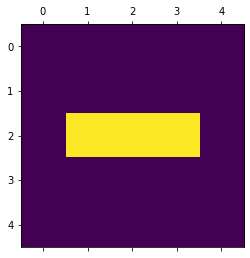

In [2]:
import multiprocessing
import threading
import random
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML
import queue

values = [0,1]
n=5
state = np.zeros((n, n)).astype(np.int8)
state[1][2]=1;
state[2][2]=1;
state[3][2]=1;

pool = multiprocessing.Pool(multiprocessing.cpu_count())

def animate(steps):
    ''' Prima niz matrica (svaka matrica je stanje u jednom koraku simulacije) 
    prikazuje razvoj sistema'''
    
    def init():
      im.set_data(steps[0])
      return [im]
    
    
    def animate(i):
      im.set_data(steps[i])
      return [im]

    im = plt.matshow(steps[0], interpolation='None', animated=True);
    
    anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                    frames=len(steps), interval=500, blit=True, repeat=False);
    return anim

def count_alive_cells(x, y):
    alive_cells = 0
    cordinates = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
    for i,j in cordinates:
      xx=x+i
      yy=y+j
      if(xx>=0 and xx<n and yy>=0 and yy<n):
        alive_cells += state[xx][yy]
    return alive_cells


def isAlive(curr_val,alive_neigbors):
    if(alive_neigbors<2 or alive_neigbors>3):
      return 0
    elif((alive_neigbors==2 or alive_neigbors==3) and curr_val==1) or (curr_val==0 and alive_neigbors==3):
      return 1
    return curr_val


def playGame(task, state):
    result = []

    for x, y in task:
        z = isAlive(state[x, y], count_alive_cells(x,y))
        result.append((x, y, z))
        
    return result


steps = []
steps.append(state.copy())


red = multiprocessing.Queue()
tasks = []
results = []

for i in range(n):
    queue = []
    for j in range(n):
        queue.append((i, j))
    tasks.append(queue)


for k in range(20):
    for task in tasks:
        results.append(pool.apply_async(playGame, args = (task, state)))

    for result in results:
        for tupl in result.get(timeout=3):
            state[tupl[0], tupl[1]] = tupl[2]

    steps.append(state.copy())

pool.close()
pool.join()

anim = animate(steps)
HTML(anim.to_html5_video())